In [1]:
import seaborn as sns
import os, re
import pandas as pd
import numpy as np
import html2text
import markdown
from bs4 import BeautifulSoup
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [2]:
def wipe_formatting(script, rehtml=False):
    parser = html2text.HTML2Text()
    parser.wrap_links = True
    parser.skip_internal_links = True
    parser.inline_links = True
    parser.ignore_anchors = True
    parser.ignore_images = True
    parser.ignore_emphasis = True
    parser.ignore_links = True
    text = parser.handle(script)
    text = text.strip(' \t\n\r')
    if rehtml:
        text = text.replace('\n', '<br/>')
        text = text.replace('\\', '')
    md = markdown.markdown(text)
    soup=BeautifulSoup(md,'html.parser')
    soup=soup.get_text()
    soup = soup.replace('\n', ' ')
    return soup

In [3]:
datadir = '../data'
fname = os.path.join(datadir, 'data.csv')
data = pd.read_csv(fname)
data.head()

,id,title,url,writers,genres,script
0,1,10 Things I Hate About You,http://www.imsdb.com/scripts/10-Things-I-Hate-...,Karen McCullah Lutz;Kirsten Smith;William Shak...,Comedy;Romance,\n\n\n<b><!--\n</b>if (window!= top)\ntop.loca...
1,2,12,http://www.imsdb.com/scripts/12.html,Lawrence Bridges,Comedy,\n\n \n 12 - Script\n
2,3,12 and Holding,http://www.imsdb.com/scripts/12-and-Holding.html,Anthony Cipriano,Drama,\n \n \n ...
3,4,12 Monkeys,http://www.imsdb.com/scripts/12-Monkeys.html,David Peoples;Janet Peoples,Drama;Sci-Fi;Thriller,\n\n\n<b><!--\n</b>if (window!= top)\ntop.loca...
4,5,12 Years a Slave,http://www.imsdb.com/scripts/12-Years-a-Slave....,John Ridley,Drama,\r\n\r\n\r\n 12 YE...


In [29]:
def generate_sh_df(movie):  # sc for scence heading
    script = data.loc[movie,'script']

    sh_pattern = '(INT.* *-+ *.+|EXT.* *-+ *.+)'
    if movie in [4,13,14,17,22,30,34,596,192]:
        sh_pattern = '(INT.+ -+ .+|EXT.+ -+ .+)\r'

    sh_list = re.findall(sh_pattern, script)
    sh_df = pd.DataFrame(columns=['movie_ID','title','I_E'
                                 ,'location','time'])

    for i, t in enumerate(sh_list):
        sh_df.loc[i, 'movie_ID'] = data.loc[movie, 'id']
        sh_df.loc[i, 'title'] = data.loc[movie, 'title']
        
        # bug alert!
        if movie in [0,13,53]:
    # L-T-T    e.g., CAFETERIA - DAY - CONTINUOUS
            location_pattern = ' +(.+) +-'
            time_pattern = '- +(.+)'

        elif movie in [14,18]:
            location_pattern = ' +(.+) +- +'
            time_pattern = '- *(.*)$'

        else:
    # L-L-T    e.g., FISHER HOME - KITCHEN - MORNING
            location_pattern = '\W+(.+) *-+ *'
            time_pattern = '-+ *(\w* *\w* *\w* *[\w\W]*)$'
    #       time_pattern = '- *(\w+ */* *\w* *\w*)$' # la la land

        sh_df.loc[i, 'I_E'] = t[0:3]
        sh_df.loc[i, 'location'] = re.findall(location_pattern, t)[0]
        sh_df.loc[i, 'time'] = re.findall(time_pattern, t)[0]

    sh_df['location'].unique()
    locations = pd.DataFrame(sh_df['location'].unique(), columns=['location'])
    locations['location_id'] = np.arange(1,len(locations)+1)
    sh_df = sh_df.merge(locations, how='left', on='location')
    sh_df['num'] = np.arange(1,len(sh_df)+1)
    sh_df['count'] = sh_df.groupby(['location'])['time'].transform('count')
    sh_df = sh_df.sort_values(by=['location_id','num']).reset_index(drop=True)
    
    return sh_df

In [33]:
def cal_location_revisit_comp(df):          
    comp = 0
    for i in range(len(df)):
        if i > 0:
            if df['location_id'][i] == df['location_id'][i-1]:
                arc_len = df['num'][i] - df['num'][i-1]
                comp += np.log2(arc_len)
    return comp         

In [31]:
def draw_location_revisits(movie):
    sh_df = generate_sh_df(movie)
    plt.rcParams['xtick.bottom'] = plt.rcParams['xtick.labelbottom'] = False
    plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = True
    plt.rcParams['ytick.left'] = True
    fig,ax = plt.subplots(figsize = [12,10])
    for i in range(len(sh_df)):
        num = sh_df['num'][i]
        loc = sh_df['location_id'][i]
        rect = patches.Rectangle((num, loc), 1, 1, linewidth = 0, edgecolor="blue",                 
                                 facecolor='paleturquoise')
        ax.add_patch(rect)
        
        if i > 0:
            if sh_df['location_id'][i] == sh_df['location_id'][i-1]:
                mid = (sh_df['num'][i-1] + sh_df['num'][i])/2
                arc_len = sh_df['num'][i] - sh_df['num'][i-1]
                arc = patches.Arc((mid+0.5, sh_df['location_id'][i]), arc_len, 9, theta1 = 0,theta2 = 180.0)
                ax.add_patch(arc)
    ax.set(xlim=[0,len(sh_df)+2],ylim=[0,len(sh_df['location'].unique())+5])
    ax.annotate(sh_df['title'][0]+f'\n{cal_location_revisit_comp(sh_df):.2f}', (5, len(sh_df['location'].unique())-5), color='m', weight='bold', fontsize=20)
    ax.invert_yaxis()  

In [36]:
generate_sh_df(647)[0:10]

,movie_ID,title,I_E,location,time,location_id,num,count
0,648,Lost in Translation,EXT,NARITA AIRPORT,NIGHT,1,1,1
1,648,Lost in Translation,INT,CHARLOTTE'S ROOM,NIGHT,2,2,5
2,648,Lost in Translation,INT,CHARLOTTE'S ROOM,DAY,2,31,5
3,648,Lost in Translation,INT,CHARLOTTE'S ROOM,NIGHT,2,68,5
4,648,Lost in Translation,INT,CHARLOTTE'S ROOM,MORNING,2,71,5
5,648,Lost in Translation,INT,CHARLOTTE'S ROOM,DAY,2,112,5
6,648,Lost in Translation,INT,CAR,NIGHT,3,3,5
7,648,Lost in Translation,INT,CAR,NIGHT,3,92,5
8,648,Lost in Translation,INT,CAR,NIGHT,3,102,5
9,648,Lost in Translation,INT,CAR,DAY,3,116,5


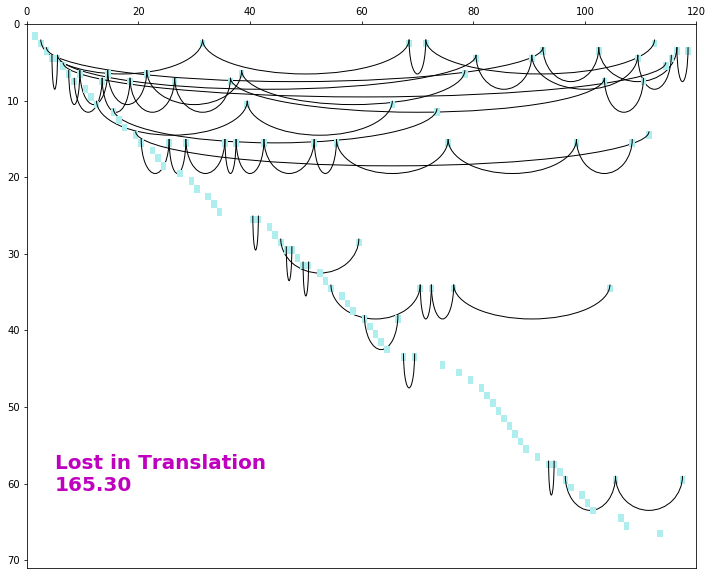

In [34]:
draw_location_revisits(647)

In [10]:
for movie in range(len(data)):
    try:
        sh_df = generate_sh_df(movie)
        comp = cal_location_revisit_comp(sh_df)
        data.loc[movie,'loc_comp'] = comp
    except:
        pass
    
data[data['loc_comp']==0] = np.nan
data = data.drop(columns=['script'])
data.to_csv('data_with_loc.csv')

In [56]:
data_wm  = pd.read_csv('data_wmetrics.csv')

In [61]:
results = pd.merge(data_wm, data, on='title', how='left')

SpearmanrResult(correlation=0.07059619816264366, pvalue=0.12972478794424375)

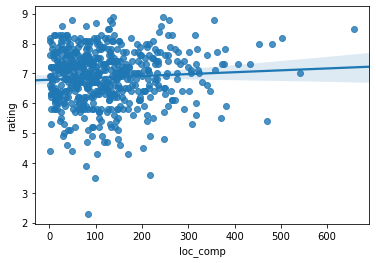

In [78]:
sns.regplot(x="loc_comp", y="rating", data=results)
sci.stats.spearmanr(results.dropna()['votes'],results.dropna()['loc_comp'])